# Question 1

a) Visualize given keypoints of an image

b) Match keypoints between images and display the top 3 matching pairs of keypoints

c) Use the top 3 pairs from b) to calculate the affine transformation between the features in the two images

d) Use the corners of the reference image to visualize the affine transformation from c)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy as sp
from skimage import color
import cv2


%matplotlib inline




In [216]:
# Question 1 a)

def visualizeKeyPoints(im, kp, num_plot):
    ''' 
    Plots keypoints over an image, including circles to indicate the range of the key points. Given the number of keypoints
    to plot, it will find n such that plotting every nth keypoint results in plotting the desired number of keypoints.
    
    im: the image from which the keypoints were extracted from
    kp: the keypoints
    num_plot: the number of keypoints to plot over the image
    '''

    kpLocs = np.zeros((num_plot,2))
    kpSizes = []
    
    n = len(kp)//num_plot + 1
    
    for i in range(np.shape(kp)[0]):
        if i%n == 0:
            x = int(np.round(kp[i].pt[0]))  # want keypoint coordinates to be integers
            y = int(np.round(kp[i].pt[1]))
            kpLocs[i//n]= [x,y] 
            
            diameter = int(np.round(kp[i].size))
            kpSizes.append(diameter/2)  # store the radii instead of diameters
            
    fig, ax = plt.subplots(1)
    
    ax.imshow(im)
    plt.plot(kpLocs[:, 0], kpLocs[:, 1],  'bo', markersize=1)  # mark the centers of the keypoints
    
    # for blah blah blah: plot circle of radius kpSizes[i] at kpLocs[i,i]
    for i in range(len(kpSizes)):
        c = Circle((kpLocs[i][0],kpLocs[i][1]),kpSizes[i], edgecolor='r', fill=False)  # use the loactions and radii of 
                                                                                        #keypoints to make a circle
        ax.add_patch(c)  # display circle over image
    
    plt.title("My visualization function \n using 100 keypoints")
    plt.show()

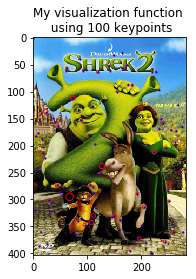

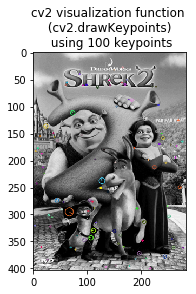

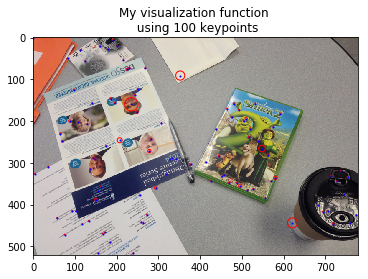

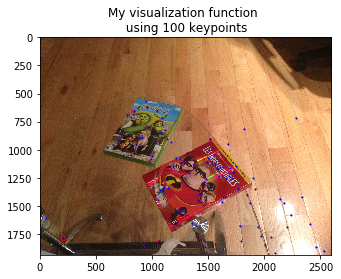

In [217]:
# Testing 1 a)

def getKeyPoints(fname):
    '''
    Gets the keypoints (using openCV) of the image located at the path fname
    '''

    # Load image and get its dimensions
    im = cv2.imread(fname)
    rows, cols, dim = im.shape

    # convert to grayscale
    gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

    # use openCV to get keypoints
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None)
    
    return kp


# Testing on reference.png

# read in image
im = plt.imread('reference.png')

# extract keypoints
kp = getKeyPoints('reference.png')

#visualize keypoints
visualizeKeyPoints(im, kp, 100)


# comparison with th cv2 method drawKeypoints
n = len(kp)//100 + 1
kp2 = []
for i in range(np.shape(kp)[0]):
        if i%n == 0:
            kp2.append(kp[i])

img = cv2.drawKeypoints(gray,kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img2 = img[:,:,::-1]
plt.imshow(img)
plt.title("cv2 visualization function \n (cv2.drawKeypoints) \n using 100 keypoints")
plt.show()



# More testing

# read in image
im = plt.imread('test.png')

# extract keypoints
kp = getKeyPoints('test.png')

#visualize keypoints
visualizeKeyPoints(im, kp, 100)

# read in image
im = plt.imread('test2.png', 0) 
# had a problem reading this image, solved by adding a zero as per 
#  https://stackoverflow.com/questions/39379609/matplotlib-valueerror-invalid-png-header

# extract keypoints
kp = getKeyPoints('test2.png')

#visualize keypoints
visualizeKeyPoints(im, kp, 100)

In [2]:
# Question 1 b)

def matchKeyPoints(im1, im2):
    '''
    Given two images, extracts keypoints for each and returns the best 3 matches between keypoints of each image
    '''
    # extract keypoints and their descriptors:
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(im1,None)
    kp2, des2 = sift.detectAndCompute(im2,None)
    
    
    matches = []  # keep track of best matches and the euclidian distances corresponding to the matches
    matches2 = []  # keep track of second best matches
    # each list above contains elements of the form [descriptor1, descriptor2, distance]
    
    matched_kp = []  # store locations of best matches for each keypoint
    # each element in the list above is of the form [keypoint1, keypoint2]
    
    # compare keypoints to find best and second best matches (from im2) for each keypoint in im1
    for im1_index in range(len(kp1)):
        best_match = None
        best_match2 = None
        min_dist = np.inf
        min_dist2 = np.inf
        best_index = None
        
        for im2_index in range(len(kp2)):
            dist = np.linalg.norm(des1[im1_index] - des2[im2_index])
            
            if dist <= min_dist:  # check if des2[im2_index] is best match so far for des1[im1_index]
                min_dist = dist
                best_match = des2[im2_index]
                best_index = im2_index
                
            elif dist <= min_dist2:  # check if it is the second best match so far
                min_dist2 = dist
                best_match2 = des2[im2_index]
                
                
        matches.append([des1[im1_index], best_match, min_dist])
        matches2.append([des1[im1_index], best_match2, min_dist2])
        matched_kp.append([kp1[im1_index], kp2[best_index]])
    
    
    # according to slide 25 from lecture 8:
    # 1) the ratio between distances to first and second best matches should be below 0.8 for a good match
    # 2) therefore, use the keypoints from im1 and their closest match from im2 that have the smallest
    #    distances, while having a ratio below 0.8
    
    
    ratios = [-np.inf, -np.inf, -np.inf]
    best_distances = [np.inf, np.inf, np.inf]  # keep track of matches with best distances (as described above)
    best_matches = [None, None, None]
    # find top 3 matches between all keypoints       
    for i in range(len(matches)):
        dist = np.abs(matches[i][2])
        ratio = np.abs(matches[i][2]/matches2[i][2])

        if ratio <= 0.8 and dist < np.max(best_distances):

            best_distances[np.argmax(best_distances)] = dist  # replace highest distance in best_distances
            best_matches[np.argmax(best_distances)] = matched_kp[i]  # replace worst match in best_matches
            ratios[np.argmax(best_distances)] = ratio
    
    
    return best_matches, best_distances, ratios


def Visualize(im1, im2, matched_kp):
    '''
    Visualizes the top 3 matched keypoints between two images
    '''
    
    colour = ['r', 'g', 'b']
    
    fig, ax = plt.subplots(1,2, figsize=(9, 3))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
    # display keypoints of first image
    for i in range(3):
        x = int(np.round(matched_kp[i][0].pt[0]))
        y = int(np.round(matched_kp[i][0].pt[1]))
        radius = int(np.round(matched_kp[i][0].size))/2

        c = Circle((x, y), 20, edgecolor=colour[i], fill=False, lw=4)  # use the loactions and radii of keypoints to make a circle
        ax[0].add_patch(c)  # display circle over image
        
    
    # display keypoints of second image
    for i in range(3):
        x = int(np.round(matched_kp[i][1].pt[0]))
        y = int(np.round(matched_kp[i][1].pt[1]))
        radius = int(np.round(matched_kp[i][1].size))/2

        c = Circle((x, y), 20, edgecolor=colour[i], fill=False, lw=4)  # use the loactions and radii of keypoints to make a circle
        ax[1].add_patch(c)  # display circle over image
    
    plt.suptitle("Top 3 matching keypoints between the images")
    plt.show()


[39.370041, 52.933922, 48.989796]
[0.14977488, 0.16410817, 0.14924033]


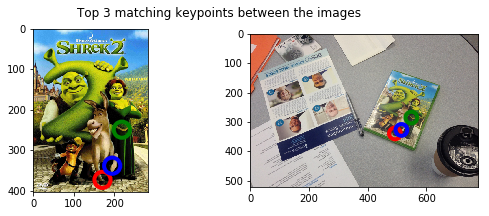

[68.905731, 80.572945, 63.237648]
[0.40930024, 0.41500559, 0.30792749]


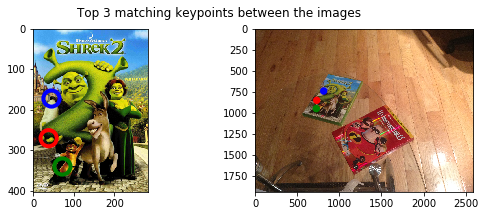

In [3]:
# Testing 1 b)

# read in images
im1 = cv2.imread('reference.png')
im2 = cv2.imread('test.png')

best_matches, best_distances, ratios = matchKeyPoints(im1, im2)
print(best_distances)
print(ratios)
   
im1 = plt.imread('reference.png')
im2 = plt.imread('test.png')
Visualize(im1, im2, best_matches)


# Testing with test2.png

# read in images
im1 = cv2.imread('reference.png')
im2 = cv2.imread('test2.png')

best_matches, best_distances, ratios = matchKeyPoints(im1, im2)
print(best_distances)
print(ratios)
   
im1 = plt.imread('reference.png')
im2 = plt.imread('test2.png', 0)
Visualize(im1, im2, best_matches)

In [6]:
# Question 1 c)

# read in images
im1 = cv2.imread('reference.png')
im2 = cv2.imread('test.png')

#get the top 3 matching keypoints
best_matches, _, _ = matchKeyPoints(im1, im2)

print("length of matches", len(best_matches))

X = []  # keypoint coordinates of reference image
T = []  # target keypoint coordinates (ie. from test.png)
for kps in best_matches:
    X.append(kps[0].pt)
    T.append(kps[1].pt)
    
X = np.array(X)
T = np.array(T)
print(X)
print(T)
print("\n")

# Solve for the affine transformation:

# convert the matrix equation to the form given by slide 42 of lecture 8
# go from AX = T to xa = t  (so now our unknown is a vector a)

t = T.ravel()
x = np.zeros((3,2,6))

for i in range(3):
    x[i] = np.array([[X[i,0], X[i,1], 0, 0, 1, 0],
                     [0, 0, X[i,0], X[i,1], 0, 1]])
x = x.reshape((6,6))    

print("x, t")
print(t)
print(x)
print("\n")

# solve for a
a = np.linalg.solve(x, t)
print(np.allclose(np.dot(x, a), t)) # test to see if solved correctly
print("\n")

# now that we solved for a, reshape it to get the Affine transformation matrix A
A = np.zeros((2,3))
A[0,0] = a[0]
A[0,1] = a[1]
A[0,2] = a[4]
A[1,0] = a[2]
A[1,1] = a[3]
A[1,2] = a[5]
print("The affine transformation matrix, A,  is:")
print(A)
print("\n")


print("The vector form, a, of the affine transformation matrix  is:")
print(a)

('length of matches', 3)
[[ 170.61291504  372.64712524]
 [ 218.53865051  249.2297821 ]
 [ 195.22135925  338.49157715]]
[[ 492.50384521  338.92987061]
 [ 549.35784912  285.06439209]
 [ 515.14154053  326.55023193]]


x, t
[ 492.50384521  338.92987061  549.35784912  285.06439209  515.14154053
  326.55023193]
[[ 170.61291504  372.64712524    0.            0.            1.            0.        ]
 [   0.            0.          170.61291504  372.64712524    0.            1.        ]
 [ 218.53865051  249.2297821     0.            0.            1.            0.        ]
 [   0.            0.          218.53865051  249.2297821     0.            1.        ]
 [ 195.22135925  338.49157715    0.            0.            1.            0.        ]
 [   0.            0.          195.22135925  338.49157715    0.            1.        ]]


True


The affine transformation matrix, A,  is:
[[  6.08496857e-01  -2.24371582e-01   4.72297848e+02]
 [  2.22787814e-01   5.22963359e-01   1.06038600e+02]]


The vect

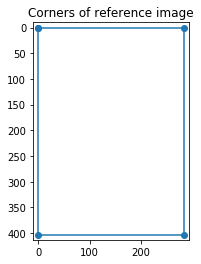

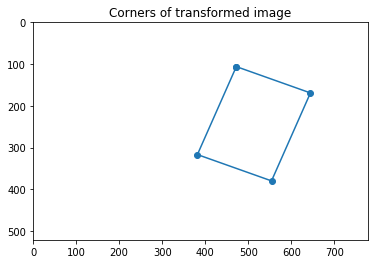

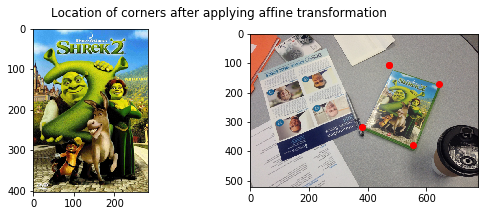

In [130]:
# Question 1 d)

# read in images
im1 = plt.imread('reference.png')
im2 = plt.imread('test.png')

corners = np.array([[0,0], 
                    [np.shape(im1)[1], 0],  
                    [np.shape(im1)[1], np.shape(im1)[0]], 
                    [0, np.shape(im1)[0]], 
                    [0,0]])

transformed_corners = np.zeros(np.shape(corners))
for i in range(len(corners)):
    transformed_corners[i] = np.matmul(A, np.concatenate((corners[i], np.array([1])), axis=None))
    # Note: the concatenate is used to add a 1 to the vectors to get them in the desired form : [x, y, 1]
    # the matmul is to apply the affine transformation

fig, ax = plt.subplots(1)
plt.plot(corners[:,0], corners[:, 1], "-o")
plt.title("Corners of reference image")
plt.xlim(-10,np.shape(im1)[1]+10)
plt.ylim(-10,np.shape(im1)[0]+10)
ax.invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


fig, ax = plt.subplots(1)
ax.plot(transformed_corners[:,0], transformed_corners[:, 1], "-o")
plt.title("Corners of transformed image")
plt.xlim(0,np.shape(im2)[1])
plt.ylim(0,np.shape(im2)[0])
ax.invert_yaxis()
plt.show()


# images for comparison
fig, ax = plt.subplots(1,2, figsize=(9, 3))

ax[0].imshow(im1)
ax[1].imshow(im2)

ax[1].plot(transformed_corners[:, 0], transformed_corners[:, 1], "ro")
plt.suptitle("Location of corners after applying affine transformation")
plt.show()